<a href="https://colab.research.google.com/github/gyanendar/ms_project/blob/main/Copy_of_CapsuleNet_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

The new model CapsuleNet proposed by Sara Sabour (and Geoffry Hinton) claims to deliver state of the art results on [MNIST](https://arxiv.org/abs/1710.09829). The kernel aims to create and train the model using the Kaggle Dataset and then make a submission to see where it actually ends up. Given the constraint of using a Kaggle Kernel means it can't be trained as long as we would like or with GPU's but IMHO if a model can't be reasonably well trained in an hour on a 28x28 dataset, that model probably won't be too useful in the immediate future.

## Implementation Details

* Keras implementation of CapsNet in Hinton's paper Dynamic Routing Between Capsules.
* Code adapted from https://github.com/XifengGuo/CapsNet-Keras/blob/master/capsulenet.py
*  Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
*     The current version maybe only works for TensorFlow backend. Actually it will be straightforward to re-write to TF code.
*     Adopting to other backends should be easy, but I have not tested this. 

Result:
    Validation accuracy > 99.5% after 20 epochs. Still under-fitting.
    About 110 seconds per epoch on a single GTX1070 GPU card
    


In [31]:
import os
import random
import cv2
import numpy as np
import pandas as pd
#from keras.preprocessing.image import ImageDataGenerator
#from keras import callbacks
import tensorflow as tf
from tensorflow.keras import callbacks
#from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


print(tf.__version__)

2.8.0


# Capsule Layers 
Here is the implementation of the necessary layers for the CapsuleNet. These are not optimized yet and can be made significantly more performant. 

In [32]:
import tensorflow.keras.backend as K
from tensorflow.keras import initializers, layers


class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional 
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = tf.sqrt(tf.reduce_sum(tf.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = tf.one_hot(indices=tf.argmax(x, 1), depth=x.shape[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * tf.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix, from each input capsule to each output capsule, there's a unique weight as in Dense layer.
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule, 1]
        inputs_expand = tf.expand_dims(tf.expand_dims(inputs, 1), -1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule, 1]
        inputs_tiled = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule, 1]
        # Regard the first two dimensions as `batch` dimension, then
        # matmul(W, x): [..., dim_capsule, input_dim_capsule] x [..., input_dim_capsule, 1] -> [..., dim_capsule, 1].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = tf.squeeze(tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled))

        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, 1, self.input_num_capsule].
        b = tf.zeros(shape=[inputs.shape[0], self.num_capsule, 1, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, 1, input_num_capsule]
            c = tf.nn.softmax(b, axis=1)

            # c.shape = [batch_size, num_capsule, 1, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [..., 1, input_num_capsule] x [..., input_num_capsule, dim_capsule] -> [..., 1, dim_capsule].
            # outputs.shape=[None, num_capsule, 1, dim_capsule]
            outputs = squash(tf.matmul(c, inputs_hat))  # [None, 10, 1, 16]

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, 1, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension, then
                # matmal:[..., 1, dim_capsule] x [..., input_num_capsule, dim_capsule]^T -> [..., 1, input_num_capsule].
                # b.shape=[batch_size, num_capsule, 1, input_num_capsule]
                b += tf.matmul(outputs, inputs_hat, transpose_b=True)
        # End: Routing algorithm -----------------------------------------------------------------------#

        return tf.squeeze(outputs)

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)


"""
# The following is another way to implement primary capsule layer. This is much slower.
# Apply Conv2D `n_channels` times and concatenate all capsules
def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    outputs = []
    for _ in range(n_channels):
        output = layers.Conv2D(filters=dim_capsule, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
        outputs.append(layers.Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))
    outputs = layers.Concatenate(axis=1)(outputs)
    return layers.Lambda(squash)(outputs)
"""

'\n# The following is another way to implement primary capsule layer. This is much slower.\n# Apply Conv2D `n_channels` times and concatenate all capsules\ndef PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):\n    outputs = []\n    for _ in range(n_channels):\n        output = layers.Conv2D(filters=dim_capsule, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)\n        outputs.append(layers.Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))\n    outputs = layers.Concatenate(axis=1)(outputs)\n    return layers.Lambda(squash)(outputs)\n'

# Build the Model
Here we use the layers to build up the model. The model is a bit different from a standard $X\rightarrow y$  model, it is $(X,y)\rightarrow (y,X)$ meaning it attempts to predict the class from the image, and then at the same time, using the same capsule reconstruct the image from the class. The approach appears very cGAN-like where the task of reconstructing better helps the model 'understand' the image data better.

In [33]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

K.set_image_data_format('channels_last')

def CapsNet(input_shape, n_class, routings, batch_size):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :param batch_size: size of batch
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape, batch_size=batch_size)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16 * n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    return train_model, eval_model, manipulate_model

In [34]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    # return tf.reduce_mean(tf.square(y_pred))
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))

    return tf.reduce_mean(tf.reduce_sum(L, 1))

In [ ]:
# define model
#(input_shape, n_class, routings, batch_size):
#model = CapsNet(input_shape=[28, 28, 1],
#                n_class=10,
#                routings=3,batch_size=100)
#model.summary()
#try:
#    plot_model(model, to_file='model.png', show_shapes=True)
#except Exception as e:
#    print('No fancy plot {}'.format(e))

# Load MNIST Data
Here we load and reformat the Kaggle contest data

In [108]:
from matplotlib import pyplot as plt
from PIL import Image
import csv
import math
import pandas

def combine_images(generated_images, height=None, width=None):
    num = generated_images.shape[0]
    if width is None and height is None:
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num)/width))
    elif width is not None and height is None:  # height not given
        height = int(math.ceil(float(num)/width))
    elif height is not None and width is None:  # width not given
        width = int(math.ceil(float(num)/height))

    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

def plot_log(filename, show=True):

    data = pandas.read_csv(filename)

    fig = plt.figure(figsize=(4,6))
    fig.subplots_adjust(top=0.95, bottom=0.05, right=0.95)
    fig.add_subplot(211)
    for key in data.keys():
        if key.find('loss') >= 0 and not key.find('val') >= 0:  # training loss
            plt.plot(data['epoch'].values, data[key].values, label=key)
    plt.legend()
    plt.title('Training loss')

    fig.add_subplot(212)
    for key in data.keys():
        if key.find('acc') >= 0:  # acc
            plt.plot(data['epoch'].values, data[key].values, label=key)
    plt.legend()
    plt.title('Training and validation accuracy')

    # fig.savefig('result/log.png')
    if show:
        plt.show()    

def test(model, data, args):
    x_test, y_test = data
    y_pred, x_recon = model.predict(x_test)#, batch_size=args.batch_size)
    print('-' * 30 + 'Begin: test' + '-' * 30)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1)) / y_test.shape[0])

    img = combine_images(np.concatenate([x_test[:50], x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save(args.save_dir + "/real_and_recon.png")
    print()
    print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
    print('-' * 30 + 'End: test' + '-' * 30)
    plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
    plt.show()

In [36]:
def train(model, data, args):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger(args.save_dir + '/log.csv')
    checkpoint = callbacks.ModelCheckpoint(args.save_dir + '/weights-{epoch:02d}.h5', monitor='val_capsnet_accuracy',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: args.lr * (args.lr_decay ** epoch))

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=args.lr),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., args.lam_recon],run_eagerly=True,
                  metrics={'capsnet': 'accuracy'})

    """
    # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint, lr_decay])
    """

    # Begin: Training with data augmentation ---------------------------------------------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield (x_batch, y_batch), (y_batch, x_batch)

    # Training with data augmentation. If shift_fraction=0., no augmentation.
    model.fit(train_generator(x_train, y_train, args.batch_size, args.shift_fraction),
              steps_per_epoch=int(y_train.shape[0] / args.batch_size),
              epochs=args.epochs,
              validation_data=((x_test, y_test), (y_test, x_test)), batch_size=args.batch_size,
              callbacks=[log, checkpoint, lr_decay])
        
    # End: Training with data augmentation -----------------------------------------------------------------------#

    model.save_weights(args.save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % args.save_dir)

    plot_log(args.save_dir + '/log.csv', show=True)

    return model


In [111]:
import argparse
import os

parser = argparse.ArgumentParser(description="Capsule Network on MNIST.")
parser.add_argument('--epochs', default=200, type=int)
parser.add_argument('--batch_size', default=64, type=int)
parser.add_argument('--lr', default=0.0001, type=float,
                        help="Initial learning rate")
parser.add_argument('--lr_decay', default=1, type=float,
                        help="The value multiplied by lr at each epoch. Set a larger value for larger epochs")
parser.add_argument('--lam_recon', default=0.392, type=float,
                        help="The coefficient for the loss of decoder")
parser.add_argument('-r', '--routings', default=8, type=int,
                        help="Number of iterations used in routing algorithm. should > 0")
parser.add_argument('--shift_fraction', default=0.1, type=float,
                        help="Fraction of pixels to shift at most in each direction.")
parser.add_argument('--debug', action='store_true',
                        help="Save weights by TensorBoard")
parser.add_argument('--save_dir', default='./result')
parser.add_argument('-t', '--testing', action='store_true',
                        help="Test the trained model on testing dataset")
parser.add_argument('--digit', default=5, type=int,
                        help="Digit to manipulate")
parser.add_argument('-w', '--weights', default=None,
                        help="The path of the saved weights. Should be specified when testing")
args, unknown = parser.parse_known_args()
print(args)

if not os.path.exists(args.save_dir):
    os.makedirs(args.save_dir)

Namespace(batch_size=64, debug=False, digit=5, epochs=200, lam_recon=0.392, lr=0.0001, lr_decay=1, routings=8, save_dir='./result', shift_fraction=0.1, testing=False, weights=None)


In [38]:
def load_mnist():
    # the data, shuffled and split between train and test sets
    #from tensorflow.keras.datasets import mnist
    #(x_train, y_train), (x_test, y_test) = mnist.load_data()
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))

    # data_slice = 10000
    # x_train = x_train[:data_slice,:]
    # y_train = y_train[:data_slice,:]
    # x_test = x_test[:data_slice,:]
    # y_test = y_test[:data_slice,:]

    return (x_train, y_train), (x_test, y_test)

In [39]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [96]:
RIM_ONE_DL_DIR = '/content/gdrive/My Drive/MSC_Project/Dataset/RIM-ONE_DL_images/partitioned_randomly'
RIM_ONE_R2_DIR = '/content/gdrive/My Drive/MSC_Project/Dataset/RIMONE-db-r2'

In [67]:
HEIGHT= 64
WIDTH = 64
BATCH_SIZE = 32
CLASS_COUNT = 2
NUM_EPOCHS_A = 25
NUM_EPOCHS_B = 40

In [71]:
# Resize image to 256*256
# Convert to numpy array
def process_image(data_set_dir, label_dict, width,height):
    
    x = [] # will store images as arrays
    y = [] # store labels
    # list folders in directory
    directories = os.listdir(data_set_dir)
     
    # for each folder (train and validation) 
    for label in directories:
        
        # add class label to label dictionary
        if label not in label_dict:
            label_dict[label] = len(label_dict)
        
        # create full path for image directory 
        source_images = os.path.join(data_set_dir, label)
        images = os.listdir(source_images)
        # for each image in directory, 
        for image in images:
            #folder have .txt files which needs to be ignored
            if '.txt'not in image:
                # read the image from file, resize and add to a list
                full_size_image = cv2.imread(os.path.join(source_images, image))
                #gray_image = cv2.cvtColor(full_size_image, cv2.COLOR_BGR2GRAY)
                
                #append the image to x
                x.append(cv2.resize(full_size_image, (width,height), 
                                                            interpolation=cv2.INTER_CUBIC))
                # add the class label to y
                y.append(label)

    data = np.array(x, dtype="float") / 255.0                
    label = np.array(y)
    
    return data,label

In [73]:
def get_rim_one_dl():
  class_labels = {}
  training_images,training_labels = process_image(RIM_ONE_DL_DIR+"/training_set",class_labels,WIDTH,HEIGHT)
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, WIDTH, WIDTH, 3).astype('float32')

  test_images,test_labels = process_image(RIM_ONE_DL_DIR+"/test_set",class_labels,WIDTH,HEIGHT)
  test_label = (pd.Series(test_labels).map(class_labels)).values
  test_label = to_categorical(test_label.astype('float32'))
  test_images = test_images.reshape(-1, WIDTH, WIDTH, 3).astype('float32')

  return (training_images,training_label),(test_images,test_label)

In [92]:
def get_rim_one_db_r2():
  class_labels = {}
  training_images,training_labels = process_image(RIM_ONE_R2_DIR,class_labels,WIDTH,HEIGHT)
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, WIDTH, WIDTH, 3).astype('float32')

  X_train, X_test, y_train, y_test = train_test_split(training_images, training_label, test_size=0.2, random_state=100)

  return (X_train,y_train),(X_test,y_test)

In [ ]:
(x_train, y_train), (x_test, y_test) = load_mnist()

In [51]:
(x1_train, y1_train), (x1_test, y1_test) = load_mnist()
(x2_train, y2_train), (x2_test, y2_test) = get_rim_one_dl()

In [ ]:
x1_train.shape

(60000, 28, 28, 1)

In [75]:
x_train.shape

(339, 64, 64, 3)

In [110]:
def set_seed(seed = 100):
  tf.random.set_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

In [112]:
set_seed()
 # load data
#(x_train, y_train), (x_test, y_test) = load_mnist()
(x_train, y_train), (x_test, y_test) = get_rim_one_db_r2()

    # define model
model, eval_model, manipulate_model = CapsNet(input_shape=x_train.shape[1:],
                                                  n_class=2,
                                                  routings=args.routings,
                                                  batch_size=args.batch_size)
model.summary()

Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(64, 64, 64, 3)]    0           []                               
                                                                                                  
 conv1 (Conv2D)                 (64, 56, 56, 256)    62464       ['input_37[0][0]']               
                                                                                                  
 primarycap_conv2d (Conv2D)     (64, 24, 24, 256)    5308672     ['conv1[0][0]']                  
                                                                                                  
 primarycap_reshape (Reshape)   (64, 18432, 8)       0           ['primarycap_conv2d[0][0]']      
                                                                                           

In [113]:
import gc
gc.collect()

3034

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


5/5 [==============================] - ETA: 0s - loss: 0.5265 - capsnet_loss: 0.4997 - decoder_loss: 0.0684 - capsnet_accuracy: 0.5562
Epoch 1: val_capsnet_accuracy improved from -inf to 0.54348, saving model to ./result/weights-01.h5
5/5 [==============================] - 8s 2s/step - loss: 0.5265 - capsnet_loss: 0.4997 - decoder_loss: 0.0684 - capsnet_accuracy: 0.5562 - val_loss: 0.4144 - val_capsnet_loss: 0.3885 - val_decoder_loss: 0.0660 - val_capsnet_accuracy: 0.5435 - lr: 1.0000e-04
Epoch 2/200
5/5 [==============================] - ETA: 0s - loss: 0.4184 - capsnet_loss: 0.3917 - decoder_loss: 0.0682 - capsnet_accuracy: 0.6020
Epoch 2: val_capsnet_accuracy did not improve from 0.54348
5/5 [==============================] - 7s 2s/step - loss: 0.4184 - capsnet_loss: 0.3917 - decoder_loss: 0.0682 - capsnet_accuracy: 0.6020 - val_loss: 0.4183 - val_capsnet_loss: 0.3925 - val_decoder_loss: 0.0659 - val_capsnet_accuracy: 0.5435 - lr: 1.0000e-04
Epoch 3/200
5/5 [========================

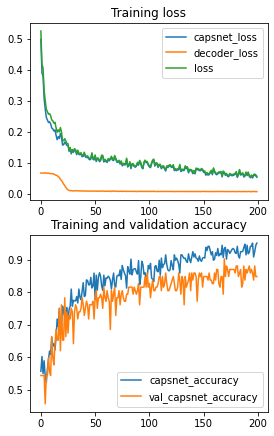

In [114]:
#train(model=model, data=((x_train, y_train), (x_test[:60], y_test[:60])), 
 #     epoch_size_frac = 0.5) # do 10% of an epoch (takes too long)
train(model=model, data=((x_train, y_train), (x_test, y_test)), args=args)

# Show the results on the hold-out


In [102]:
y_test.shape

(92, 2)

In [109]:


test(model=eval_model, data=(x_test, y_test), args=args)


InvalidArgumentError: ignored

In [ ]:
# pick some collabs stuff 